In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# import excel file
df_test = pd.read_excel('sampledata_communitypillars.xlsx', )

In [28]:
df_test = df_test.rename(columns={0: '0.0', 0.5:'0.5', 1:'1.0'})

In [55]:
# make id column the index
df_test = df_test.set_index('id')
df_test

,0.0,0.5,1.0
id,,,
1000,1,1,1
2000,1,1,2
3000,1,1,3
4000,1,2,4
5000,1,2,5
6000,2,2,6
7000,2,2,5
8000,2,3,7


In [56]:
# create a function that takes in two lists of id numbers and returns the jaccard sim of the two lists
def calculate_difference(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    unique_1 = set1-set2
    unique_2 = set2-set1

    # Union of set1 and set 2
    union_1_2 = set1 | set2
    common = set1.intersection(set2)
    jaccard_sim = len(common) / len(union_1_2)

    return unique_1, unique_2, common, jaccard_sim

# function that takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare
def get_body_ids(df, coarse_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare. 
    It returns a dictionary of body IDs for each cluster number at the resolution and a dictionary of body IDs for each cluster 
    number at the base resolution."""
    # Need bodyIds at zero resolution for each cluster number
    dict_zero = {1: [], 2: [],}
    for key, value in dict_zero.items():
        dict_zero[key] = df[df['0.0']==key].index.tolist()

    # Gets cluster numbers for resolution
    chi_values = [chi]
    cluster_all = np.zeros((len(coarse_modules),len(chi_values), 800))
    for i, x in enumerate(coarse_modules):
        df_test = df[df['0.0']==x]
        for f, y in enumerate(chi_values):
            cluster = df_test[y].unique()
            cluster_all[i,f, :len(cluster)] = cluster

    # move everything to a dictionary
    dict = {}
    for i, x in enumerate(coarse_modules):
        dict[coarse_modules[i]] = cluster_all[i,0]
    
    # Remove the zeros from the array
    for key, value in dict.items():
        dict[key] = value[value != 0]
        dict[key] = np.array(value, dtype='int64')
    
    # Get bodyIDs for each cluster number in the resolution
    dict_new = {1: [], 2: []}
    for key, value in dict.items():
        body_ids = []
        for i, x in enumerate(value):
            body_ids.extend(df[df[chi]==x].index.tolist())
        dict_new[key] = body_ids

    return dict_new, dict_zero
    
# Function that takes in partition dataframe, the modules at the base resolution, and the chi value at which to compare
def main_jaccard(df, coarse_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi 
    value at which to compare. It returns a dataframe of the jaccard similarities between the resolutions at each cluster"""

    # Get the body IDs for each cluster number at the resolution and the base resolution
    dict_new, dict_zero = get_body_ids(df, coarse_modules, chi)

    # Create a dictionary to store the jaccard similarities
    jaccard_dict = {}
    for key, value in dict_new.items():
        jaccard_dict[key] = []
        unique_1, unique_2, common, jaccard_sim = calculate_difference(dict_new[key], dict_zero[key])
        jaccard_dict[key].append(jaccard_sim)
    
    # Create a dataframe to store the jaccard similarities
    df_jaccard = pd.DataFrame(jaccard_dict)
    df_jaccard.index = np.arange(1, len(df_jaccard)+1)
    
    return df_jaccard, dict_new, dict_zero

In [57]:
coarse_modules = [1, 2]
jaccard_values, dict_new, dict_zero = main_jaccard(df_test, coarse_modules, '0.5')

In [58]:
jaccard_values1, dict_new1, dict_zero1 = main_jaccard(df_test, coarse_modules, '1.0')

In [59]:
jaccard_values = jaccard_values._append(jaccard_values1)
jaccard_values = jaccard_values.T
jaccard_values.columns = ['0.5','1.0']
jaccard_values

,0.5,1.0
1,0.714286,0.833333
2,0.600000,0.750000


Text(0.5, 1.0, 'Jaccard Similarity between 0.0 and 0.1, 0.25')

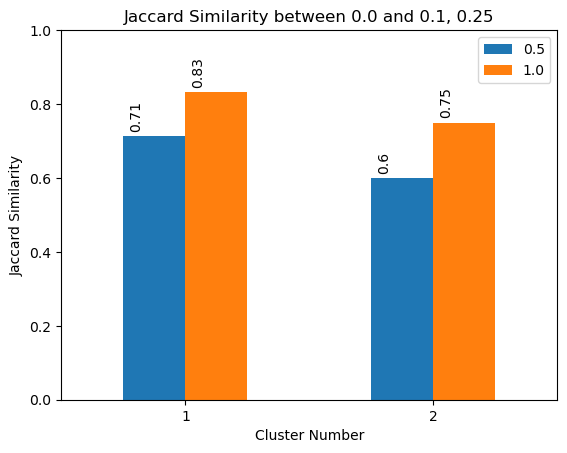

In [60]:
fig, ax  = plt.subplots()
jaccard_values.plot(kind='bar', ax=ax)

# annotate with value of each bar from jaccard_values dataframe
for i, v in enumerate(jaccard_values['0.5']):
    ax.text(i-0.2, v+.02, round(v, 2), color='black', ha='center', rotation=90)
for i, v in enumerate(jaccard_values['1.0']):
    ax.text(i+0.05, v+.02, round(v, 2), color='black', ha='center', rotation=90)
ax.set_ylim(0, 1)
ax.set_xticklabels(['1', '2'], rotation=0)
ax.set_xlabel('Cluster Number')
ax.set_ylabel('Jaccard Similarity')
ax.set_title('Jaccard Similarity between 0.0 and 0.1, 0.25')

In [61]:
dict_zero, dict_new

({1: [1000, 2000, 3000, 4000, 5000], 2: [6000, 7000, 8000]},
 {1: [1000, 2000, 3000, 4000, 5000, 6000, 7000],
  2: [4000, 5000, 6000, 7000, 8000]})

In [62]:
dict_zero1, dict_new1

({1: [1000, 2000, 3000, 4000, 5000], 2: [6000, 7000, 8000]},
 {1: [1000, 2000, 3000, 4000, 5000, 7000], 2: [6000, 5000, 7000, 8000]})

In [63]:
# check if an id has 1 in 0.0 
list_to_check

Cluster Number: 1
Resolution: [1000, 2000, 3000, 4000, 5000, 6000, 7000]
Base Resolution: [1000, 2000, 3000, 4000, 5000]
Jaccard Similarity: 0.7142857142857143


Cluster Number: 2
Resolution: [4000, 5000, 6000, 7000, 8000]
Base Resolution: [6000, 7000, 8000]
Jaccard Similarity: 0.6


